# Градиентный бустинг (Gradient Boosting)

В программе:
* обучение бустинга и сравнение с лесом
* подбор гиперпараметров бустинга
* зависимость качества от числа деревьев

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.datasets import fetch_california_housing

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import r2_score

In [ ]:
RANDOM_STATE = 42

In [ ]:
data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

## 1. Сравнение дерева и леса

In [ ]:
rf = RandomForestRegressor()

cross_val_score(rf, X, y, cv=3, scoring='r2').mean()

0.6550731065121949

In [ ]:
gb = GradientBoostingRegressor()

cross_val_score(gb, X, y, cv=3, scoring='r2').mean()

0.6800438496919287

## 2. Подбор гиперпараметров бустинга

Напомним, как мы действуем при подборе гиперпараметров:
* разбиваем данные на *train* и *test*
* на *train* по кросс-валидации при помощи `GridSearchCV` ищем наилучшие гиперпараметры модели
* оцениваем качество модели с наилучшими гиперпараметрами на *test*

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

### Гиперпараметры бустинга (gradient boosting)

* `n_estimators=100` - число деревьев в лесе 
* `learning_rate=0.1` - градиентный шаг (= степень доверия каждой модели в композиции)
* гиперпараметры деревьев (обсуждали раньше):
  * `criterion='squared_error'`
  * `max_depth=None`
  * `min_samples_split=2`
  * ...
  * `random_state=None`


In [ ]:
params = {'n_estimators': np.arange(10, 200, 20),
          'max_depth': np.arange(2, 20, 3)}

gs = GridSearchCV(GradientBoostingRegressor(), params, cv=3, scoring='r2', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.5s
[CV] END .......................max_depth=2, n_estimators=50; total time=   1.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   1.1s
[CV] END .......................max_depth=2, n_estimators=50; total time=   0.9s
[CV] END .......................max_depth=2, n_estimators=70; total time=   1.1s
[CV] END .......................max_depth=2, n_estimators=70; total time=   1.1s
[CV] END .......................max_depth=2, n_

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': array([ 2,  5,  8, 11, 14, 17]),
                         'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190])},
             scoring='r2', verbose=2)

In [ ]:
gs.best_score_, gs.best_estimator_

(0.8244124183295582, GradientBoostingRegressor(max_depth=8, n_estimators=190))

In [ ]:
params = {'max_features': [None, 'sqrt', 'log2']}

gs = GridSearchCV(GradientBoostingRegressor(n_estimators = 170, max_depth = 8), params, cv=3, scoring='r2', verbose=2)

gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ..................................max_features=None; total time=  10.1s
[CV] END ..................................max_features=None; total time=  10.5s
[CV] END ..................................max_features=None; total time=  10.5s
[CV] END ..................................max_features=sqrt; total time=   2.7s
[CV] END ..................................max_features=sqrt; total time=   2.7s
[CV] END ..................................max_features=sqrt; total time=   3.5s
[CV] END ..................................max_features=log2; total time=   3.9s
[CV] END ..................................max_features=log2; total time=   3.9s
[CV] END ..................................max_features=log2; total time=   4.7s


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(max_depth=8, n_estimators=170),
             param_grid={'max_features': [None, 'sqrt', 'log2']}, scoring='r2',
             verbose=2)

In [ ]:
gs.best_score_, gs.best_estimator_

(0.8296675722761929,
 GradientBoostingRegressor(max_depth=8, max_features='log2', n_estimators=170))

Теперь проверим полученную модель на тестовых данных

In [ ]:
model = GradientBoostingRegressor(n_estimators = 170, learning_rate = 0.1, max_depth = 8, max_features='log2')

model.fit(Xtrain, ytrain)

pred = model.predict(Xtest) 

r2_score(ytest, pred)

0.8442035390010441

На качество бустинга влияет `learning_rate`.

Стратегия такая: после подбора гиперпараметров мы уменьшаем `learning_rate` до 0.01-0.03  
(то есть если значение по умолчанию 0.1, то уменьшаем в 10 раз), и во столько же раз увеличиваем число деревьев.

In [ ]:
model = GradientBoostingRegressor(n_estimators = 1700, learning_rate = 0.01, max_depth = 8, max_features='log2')

model.fit(Xtrain, ytrain)

pred = model.predict(Xtest) 

r2_score(ytest, pred)

0.8505992113044265

При помощи случайного леса в предыдущем уроке нам удалось добиться качества $r2=0.812$.

Мы видим, что в этой задаче бустинг значительно превзошел по качеству алгоритм случайного леса!

## 3. Поведение модели при увеличении числа деревьев

Text(0, 0.5, 'r2')

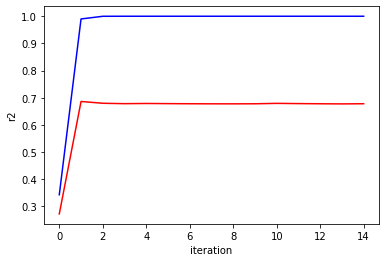

In [ ]:
r2_train = []
r2_test = []

for n in range(2, 300, 20):
    model = GradientBoostingRegressor(n_estimators = n, max_depth = 20)
    model.fit(Xtrain, ytrain)

    pred_train = model.predict(Xtrain)
    pred_test = model.predict(Xtest)

    r2_train.append(r2_score(ytrain, pred_train))
    r2_test.append(r2_score(ytest, pred_test))

plt.plot(r2_train, color='blue')
plt.plot(r2_test, color='red')
plt.xlabel('iteration')
plt.ylabel('r2')

Эти графики подтверждают теорию: при увеличении числа деревьев в бустинге качество на тренировочных данных сначала растет, а потом начинает уменьшаться (так как начинается переобучение).

Поэтому на практике необходимо подобрать такое число деревьев, при котором качество на тестовых данных максимальное (и больше деревьев не брать!). В этом одно из важных отличий бустинга от леса.